In [0]:
# import libraries
import json
import math
import os
import random
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import DenseNet201
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img

In [0]:
input_dir = "/content/drive/My Drive/chest-xray-pneumonia/chest_xray/"
train_dir = "/content/drive/My Drive/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/drive/My Drive/chest-xray-pneumonia/chest_xray/test"
val_dir = "/content/drive/My Drive/chest-xray-pneumonia/chest_xray/val"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


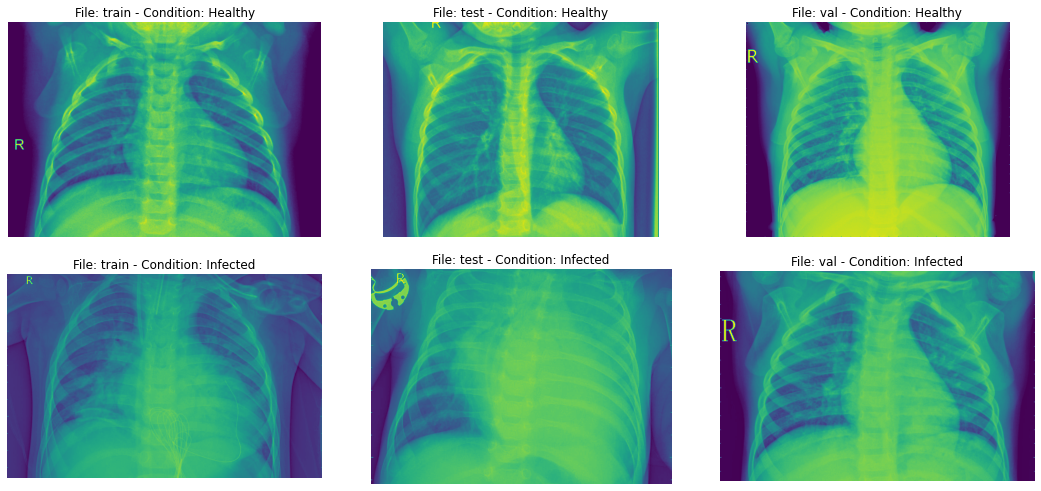

In [4]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Create DenseNet201 Model with Keras library

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(densenet ,lr = 1e-4)
model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,331,585
Trainable params: 18,098,689
Non-trainable params: 232,896
_________________________________________________________________


In [9]:
# Fit Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=test_generator,
    validation_steps=10
)

Epoch 1/10
100/100 [==============================] - 1162s 12s/step - loss: 0.3467 - acc: 0.8605 - val_loss: 0.7053 - val_acc: 0.6250
Epoch 2/10
100/100 [==============================] - 1044s 10s/step - loss: 0.2015 - acc: 0.9289 - val_loss: 0.6782 - val_acc: 0.6550
Epoch 3/10
100/100 [==============================] - 1026s 10s/step - loss: 0.1675 - acc: 0.9535 - val_loss: 0.2623 - val_acc: 0.9250
Epoch 4/10
100/100 [==============================] - 1011s 10s/step - loss: 0.1606 - acc: 0.9479 - val_loss: 0.4419 - val_acc: 0.6467
Epoch 5/10
100/100 [==============================] - 1021s 10s/step - loss: 0.1677 - acc: 0.9450 - val_loss: 0.6285 - val_acc: 0.7000
Epoch 6/10
100/100 [==============================] - 1036s 10s/step - loss: 0.1048 - acc: 0.9624 - val_loss: 0.7700 - val_acc: 0.7300
Epoch 7/10
100/100 [==============================] - 1118s 11s/step - loss: 0.0913 - acc: 0.9660 - val_loss: 0.9725 - val_acc: 0.7065
Epoch 8/10
100/100 [==============================] - 1

In [11]:
score = model.evaluate_generator(test_generator,verbose=1)
print("The accuracy is ",score[1])

32/32 [==============================] - 103s 3s/step
The accuracy is  0.7211538553237915


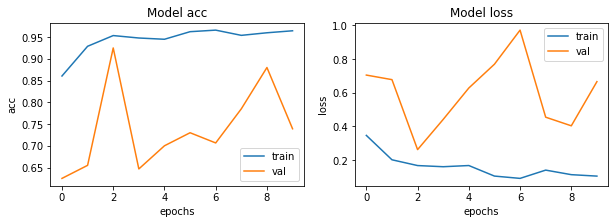

In [13]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [0]:
# model save
model.save_weights("cnn-example-pneumonia-densenet201.h5")

Actual class: NORMAL
Predicted class: Normal
Likelihood: 0.0
WARNING, low confidence


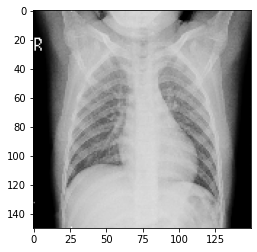

In [29]:
def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob(r'/content/drive/My Drive/chest-xray-pneumonia/chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(150, 150))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_class = model.predict_classes(x)
    pred = model.predict(x)
    print("Actual class:", folder_choice)
    if pred_class[0] == 0:
        print("Predicted class: Normal")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    else:
        print("Predicted class: Pneumonia")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")        
        
choose_image_and_predict()